In [2]:
# 多数投票
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])) # np.bincount统计每个索引出现的次数；argmax得到最大值对应的索引

1

In [4]:
# 加权多数投票
ex = np.mat([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
np.argmax(p)

0

In [5]:
"""基于python实现MajorityVoteClassifier"""

'基于python实现MajorityVoteClassifier'

In [22]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """fit classifier"""
        self.labelnc_ = LabelEncoder()
        self.labelnc_.fit(y)
        self.classes_ = self.labelnc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelnc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """predict the classlabel for X"""
        if self.vote == 'probability': # 基于概率预测
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.argmax(np.bincount(predictions, weights=self.weights))
        maj_vote = self.labelnc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """Predict class probabilities for X"""
        probs = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probs, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers): # 获得每个分类器的所有超参
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [7]:
"""MajorityVoteClassifier实战"""
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder() # 确保类标从0开始
y = le.fit_transform(y)

In [8]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [12]:
y_train

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0])

In [16]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
# 先通过十折交叉验证计算单个分类器的性能（评价指标为roc_auc曲线面积）
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([('sc', StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()), ('clf', clf3)])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [23]:
my_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, my_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


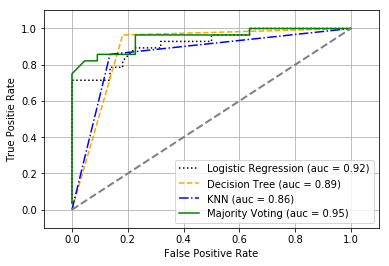

In [26]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyle = [':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
    "假设1为正例"
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr) # auc（roc曲线面积）
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],linestyle='--',color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positie Rate')
plt.show()

In [27]:
my_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [28]:
# 网格搜索调参
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1,2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=my_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f +/- %0.2f %r" % (mean_score, scores.std(), params))

0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [29]:
print('best params: {}, best accuracy: {}'.format(grid.best_params_, grid.best_score_))

best params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}, best accuracy: 1.0


In [32]:
my_bst_clf = grid.best_estimator_

In [33]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'MyBestCLF']
for clf, label in zip([pipe1, clf2, pipe3, my_bst_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 1.00 (+/- 0.00) [MyBestCLF]


In [34]:
"""通过bootstrap构建集成分类器"""

'通过bootstrap构建集成分类器'

In [36]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1] # 只选取2\3类
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [38]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True,
                       bootstrap_features=False, n_jobs=-1, random_state=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train accuracy: %.3f, test accuracy: %.3f' % (tree_train, tree_test))

Decision tree train accuracy: 1.000, test accuracy: 0.854


In [40]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train accuracy: %.3f, test accuracy: %.3f' % (bag_train, bag_test))

Decision tree train accuracy: 1.000, test accuracy: 0.896


In [43]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1) # 单层树桩
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train accuracy: %.3f, test accuracy: %.3f' % (tree_train, tree_test))
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train accuracy: %.3f, test accuracy: %.3f' % (ada_train, ada_test))

Decision tree train accuracy: 0.845, test accuracy: 0.854
Decision tree train accuracy: 1.000, test accuracy: 0.875
